# CMPUT 466/566: Machine Learning, Assignment 1
This notebook allows you to run both Decision Tree and Naive Bayes.  
Please use Python 3.10.13

In [1]:
!pip install numpy==1.26.3
!pip install matplotlib==3.8.2

In [2]:
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import timeit

from functools import partial

from decision_tree import *
from naive_bayes import *

# Debug

## Decision Tree

In [3]:
def test_dt():
    with open('./datasets/test_dt.pkl', 'rb') as f:
        test = pickle.load(f)

    seed = 0
    num_classes = 2
    max_depth = 10
    min_leaf_data = 10
    min_entropy = 1e-3
    num_split_retries = 10
    debug = False

    # 1-D Linear Seperable
    X_1 = test['X_1']
    y_1 = test['y_1']
    tree = train_dt(X_1,
                    y_1,
                    seed,
                    max_depth,
                    min_leaf_data,
                    min_entropy,
                    num_split_retries,
                    num_classes,
                    debug)
    print('Correct Pred 1-D Linear Seperable, 2 class: {}'.format(np.allclose(predict_dt(tree, X_1), test['pred_1'])))

    # 1-D Random, 2 Class
    X_2 = test['X_2']
    y_2 = test['y_2']
    tree = train_dt(X_2,
                    y_2,
                    seed,
                    max_depth,
                    min_leaf_data,
                    min_entropy,
                    num_split_retries,
                    num_classes,
                    debug)
    print('Correct Pred 1-D Random, 2 class: {}'.format(np.allclose(predict_dt(tree, X_2), test['pred_2'])))

    # Optional TODO: Add your own test cases

test_dt()

Correct Pred 1-D Linear Seperable, 2 class: True
Correct Pred 1-D Random, 2 class: True


## Naive Bayes

In [4]:
def test_nb():
    with open('./datasets/test_nb.pkl', 'rb') as f:
        gt_data = pickle.load(f)
        data = gt_data["nb"]

    num_features = gt_data["X"].shape[1]
    num_classes = len(np.unique(gt_data["y"]))
    params = train_nb(gt_data["X"], gt_data["y"], num_classes)

    correct_means = np.allclose(params.means, data["means"])
    correct_covariances = np.allclose(params.covariances, data["covariances"])
    correct_priors = np.allclose(params.priors, data["priors"])

    correct_params = Params(data["means"],
                            data["covariances"],
                            data["priors"],
                            num_features,
                            num_classes)
    model_probs = predict_nb(correct_params, gt_data["X"])
    correct_predictions = np.allclose(model_probs, data["predictions"])

    print(f"Correct Means: {correct_means}")
    print(f"Correct Covariances: {correct_covariances}")
    print(f"Correct Priors: {correct_priors}")
    print(f"Correct Predictions: {correct_predictions}")

    print("Details:")
    if not correct_means:
        print("Expected Mean:")
        print(data["means"])
        print("Got:")
        print(params.means)

    if not correct_covariances:
        print("Expected Covariances:")
        print(data["covariances"])
        print("Got:")
        print(params.covariances)

    if not correct_priors:
        print("Expected Priors:")
        print(data["priors"])
        print("Got:")
        print(params.priors)

    if not correct_predictions:
        print("Expected Predictions:")
        print(data["predictions"])
        print("Got:")
        print(model_probs)

    print("=" * 75)

    # Optional TODO: Add your own test cases

test_nb()

Correct Means: True
Correct Covariances: True
Correct Priors: True
Correct Predictions: True
Details:


# Lending Club

### Helper Functions

In [5]:
def get_dataset_info():
    with open("./datasets/lending_club.pkl", "rb") as f:
        lc_data =  pickle.load(f)

    # Train data
    train_X = lc_data['train_X']
    train_y = lc_data['train_y']
    
    # Validation data
    validation_X = lc_data['validation_X']

    num_features = train_X.shape[-1]
    num_classes = len(np.unique(train_y))

    print("Dataset Information =============================")
    print("Number of input features: {}, Number of classes: {}".format(num_features, num_classes))
    print("Number training points: {}".format(len(train_X)))
    print("Number validation points: {}".format(len(validation_X)))
    return num_features, num_classes

def accuracy(y, p):
    """ This returns the accuracy of prediction given true labels.

    Args:
    - y (ndarray (shape: (N,1))): A Nx1 matrix consisting of true labels
    - p (ndarray (shape: (N,C))): A NxC matrix consisting N C-dimensional probabilities for each input.
    
    Output:
    - acc (float): Accuracy of predictions compared to true labels
    """
    assert y.shape[0] == p.shape[0], f"Number of samples must match"

    # Pick indicies that maximize each row
    y_pred = np.expand_dims(np.argmax(p, axis=1), axis=1)
    acc = sum(y_pred == y) * 100 / y.shape[0]

    return acc

def print_result(train_accs, val_accs, test_accs):
    mean_train = np.mean(train_accs, axis=(-1, -2))
    std_train = np.std(train_accs, axis=(-1, -2))

    mean_val = np.mean(val_accs, axis=(-1, -2))
    std_val = np.std(val_accs, axis=(-1, -2))

    print("Train accuracy: {}% +/- {}".format(mean_train, std_train,))
    print("Validation accuracy: {}% +/- {}".format(mean_val, std_val,))

    mean_test = None
    std_test = None
    if len(test_accs):
        mean_test = np.mean(test_accs, axis=(-1, -2))
        std_test = np.std(test_accs, axis=(-1, -2))
        print("Test accuracy: {}% +/- {}".format(mean_test, std_test))

## Run Lending Club Experiments

In [6]:
def run_lc(train, predict, final_hyperparameters, seed, num_runs):
    # Load dataset
    with open("./datasets/lending_club.pkl", "rb") as f:
        lc_data =  pickle.load(f)

    # Train data
    train_X = lc_data['train_X']
    train_y = lc_data['train_y']
    
    # Validation data
    validation_X = lc_data['validation_X']
    validation_y = lc_data['validation_y']

    # Test data
    test_X, test_y = None, None
    if final_hyperparameters:
        test_X = lc_data['test_X']
        test_y = lc_data['test_y']

    train_accs = []
    validation_accs = []
    test_accs = []
    train_times = []

    rng = np.random.RandomState(seed)
    seeds = rng.randint(0, 2 ** 32 - 1, size=(num_runs,))
    for run_seed in seeds:
        tic = timeit.default_timer()
        params = train(train_X, train_y, seed=run_seed)
        toc = timeit.default_timer()
        train_times.append(toc - tic)

        # Training Accuracy
        train_predictions = predict(params, train_X)
        train_accs.append(accuracy(train_y, train_predictions))

        if validation_X is not None and validation_y is not None:
            # Validation Accuracy
            validation_predictions = predict(params, validation_X)
            validation_accs.append(accuracy(validation_y, validation_predictions))

        if test_X is not None and test_y is not None:
            # Testing Accuracy
            test_predictions = predict(params, test_X)
            test_accs.append(accuracy(test_y, test_predictions))

    return train_accs, validation_accs, test_accs, train_times, seeds

In [7]:
num_features, num_classes = get_dataset_info()

Dataset Information =============================
Number of input features: 21, Number of classes: 2
Number training points: 74176
Number validation points: 18544


## Decision Tree

### Plot train/validation curves
Note: This may take around 6.5 minutes to run, longer with inefficient code

In [8]:
max_depths = [1, 2, 4, 8, 16, 20]

seed = 42
num_runs = 5
train_accs = []
val_accs = []
times_taken = []
for max_depth in max_depths:
    print("=" * 50)
    print("max_depth = {}".format(max_depth))
    curr_train_accs, curr_val_accs, _, curr_times_taken, seeds = run_lc(
        train=partial(train_dt,
                      max_depth=max_depth,
                      min_leaf_data=1,
                      min_entropy=0.0,
                      num_split_retries=num_features,
                      debug=False,
                      num_classes=num_classes,),
        predict=predict_dt,
        final_hyperparameters=False,
        seed=seed,
        num_runs=num_runs,
    )
    times_taken.append(curr_times_taken)
    train_accs.append(curr_train_accs)
    val_accs.append(curr_val_accs)
    print("Seeds: {}".format(seeds))
    print("Average train accuracy: {}% +/- {}".format(np.mean(curr_train_accs), np.std(curr_train_accs)))
    print("Average validation accuracy: {}% +/- {}".format(np.mean(curr_val_accs), np.std(curr_val_accs)))
    print("Total time taken: {}s".format(np.sum(curr_times_taken)))
    print("Average time taken: {}s +/- {}".format(np.mean(curr_times_taken), np.std(curr_times_taken)))
    print("=" * 50)
    print("")

max_depth = 1
Seeds: [1608637542 3421126067 4083286876  787846414 3143890026]
Average train accuracy: 53.72762079378774% +/- 4.507698073615171
Average validation accuracy: 53.855694564279545% +/- 4.573529563994521
Total time taken: 15.483151774998987s
Average time taken: 3.0966303549997973s +/- 0.947429680103785

max_depth = 2
Seeds: [1608637542 3421126067 4083286876  787846414 3143890026]
Average train accuracy: 58.21047238999138% +/- 1.6476783393428287
Average validation accuracy: 58.40811044003451% +/- 1.7190928708947109
Total time taken: 26.571092818994657s
Average time taken: 5.314218563798931s +/- 0.9969070739743742

max_depth = 4
Seeds: [1608637542 3421126067 4083286876  787846414 3143890026]
Average train accuracy: 59.272271354616045% +/- 0.004777837884670908
Average validation accuracy: 59.46721311475409% +/- 0.01110400144627733
Total time taken: 53.28742402800344s
Average time taken: 10.657484805600689s +/- 1.066826955275016

max_depth = 8
Seeds: [1608637542 3421126067 408328

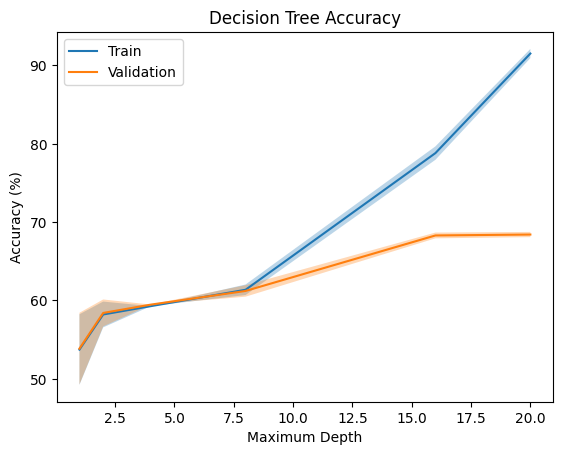

In [9]:
mean_train = np.mean(train_accs, axis=(-1, -2))
std_train = np.std(train_accs, axis=(-1, -2))

mean_val = np.mean(val_accs, axis=(-1, -2))
std_val = np.std(val_accs, axis=(-1, -2))

plt.plot(max_depths, mean_train, label="Train")
plt.fill_between(max_depths, mean_train - std_train, mean_train + std_train, alpha=0.3)

plt.plot(max_depths, mean_val, label="Validation")
plt.fill_between(max_depths, mean_val - std_val, mean_val + std_val, alpha=0.3)

plt.title("Decision Tree Accuracy")
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy (%)")
plt.legend()

Based on the above curve, for which value of `maximum_depth` will you choose? Why?  
Enter solution in the block below:
```
TODO: Answer
Based on the curve, we should choose depth at around 16 as the accuracy is still increasing between 0 and 16. The accuracy stagnates at max depth 16 and unable to find any useful information afterwards thus 16 is the best choice.
```

Given the above observation, can you find the best hyperparameters that will achieve the best performance?

In [23]:
# TODO: validation set to tune hyperparameters for the Occupancy dataset
# For efficiency, consider max_depth <= 10.
hyperparameters = {
    "max_depth": 10,
    "min_leaf_data": 1,
    "min_entropy": 0,
    "num_split_retries": num_features,
    "debug": False,
    "num_classes": num_classes
}

# TODO: Set final_hyperparameters to True when best hyperparameters is found
train_accs, val_accs, test_accs, _, _ = run_lc(train=partial(train_dt,
                                                             **hyperparameters),
                                               predict=predict_dt,
                                               final_hyperparameters=True,
                                               seed=seed,
                                               num_runs=num_runs)

print_result(train_accs, val_accs, test_accs)

Train accuracy: 64.76326574633306% +/- 0.8067993264328617
Validation accuracy: 64.20189818809317% +/- 0.8699259206737192
Test accuracy: 64.17773943054357% +/- 0.8051416310727013


## Naive Bayes

In [11]:
train_acc, val_acc, test_acc, _, _ = run_lc(train=partial(train_nb,
                                                          num_classes=num_classes),
                                            predict=predict_nb,
                                            final_hyperparameters=True,
                                            seed=seed,
                                            num_runs=1)
print("Train accuracy: {}%, Validation accuracy: {}%, Test accuracy: {}%".format(train_acc, val_acc, test_acc))

/home/main/basicallyDesktop/math_uofa/cmput466/starter/naive_bayes.py:125: RuntimeWarning: invalid value encountered in scalar divide
  probs[i][j] = unnormalized_probs[i][j] / total


Train accuracy: [array([69.9646786])]%, Validation accuracy: [array([69.64516825])]%, Test accuracy: [array([69.36151855])]%


Which model will you choose? Why?  
Enter solution in the block below:
```
TODO: Answers
Naive Bayes as it is both faster and having higher accuracy.
```

### Credit
CMPUT 466/566 - Machine Learning, Winter 2024, Assignment 1  
B. Chan